In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np
import minari
from torch import autograd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

# ------------------------------------------------------------
# 1️⃣ Dataset Flattening (unchanged)
# ------------------------------------------------------------
def flatten_minari_dataset(dataset):
    obs_list, act_list, rew_list, next_obs_list, term_list = [], [], [], [], []
    for ep in dataset.iterate_episodes():
        obs_data = ep.observations
        acts = np.asarray(ep.actions)
        rews = np.asarray(ep.rewards)
        terms = np.asarray(ep.terminations)
        if len(acts) < 1:
            continue

        if isinstance(obs_data, dict):
            obs = np.concatenate([np.asarray(v) for v in obs_data.values()], axis=-1)
        elif isinstance(obs_data[0], dict):
            obs = [np.concatenate([v.flatten() for v in o.values()]) for o in obs_data]
            obs = np.stack(obs)
        else:
            obs = np.asarray(obs_data)
        if obs.shape[0] <= 1:
            continue

        s = obs[:-1]
        s2 = obs[1:]
        a = acts[:len(s)]
        r = rews[:len(s)]
        done = terms[:len(s)] if len(terms) == len(s) else np.zeros_like(r)
        obs_list.append(s)
        act_list.append(a)
        rew_list.append(r.reshape(-1, 1))
        next_obs_list.append(s2)
        term_list.append(done.reshape(-1, 1))

    s_all  = torch.tensor(np.concatenate(obs_list, axis=0), dtype=torch.float32)
    a_all  = torch.tensor(np.concatenate(act_list, axis=0), dtype=torch.float32)
    r_all  = torch.tensor(np.concatenate(rew_list, axis=0), dtype=torch.float32)
    s2_all = torch.tensor(np.concatenate(next_obs_list, axis=0), dtype=torch.float32)
    d_all  = torch.tensor(np.concatenate(term_list, axis=0), dtype=torch.float32)
    print(f"Flattened dataset: {s_all.shape[0]} transitions")
    print(f"State dim: {s_all.shape[1]}, Action dim: {a_all.shape[1]}")
    return s_all, a_all, r_all, s2_all, d_all


In [ ]:

# ------------------------------------------------------------
# 2️⃣ Networks
# ------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x): return self.net(x)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = MLP(state_dim, action_dim)
    def forward(self, s): return torch.tanh(self.net(s))

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = MLP(state_dim + action_dim, 1)
    def forward(self, s, a): return self.net(torch.cat([s, a], -1))



In [ ]:

#state consistency
def first_order_term_for_Q(Q, s, a, s2, g_a):
    # Create leaf tensors for gradient computation to avoid in-place modification issues
    s_leaf = s.detach().clone().requires_grad_(True)
    a_leaf = a.detach().clone().requires_grad_(True)

    # Compute Q(s,a) and its gradients w.r.t. state and action
    Q_sa = Q(s_leaf, a_leaf)
    grad_s = autograd.grad(Q_sa.sum(), s_leaf, create_graph=True)[0]  # ∇sQ
    grad_a = autograd.grad(Q_sa.sum(), a_leaf, create_graph=True)[0]  # ∇aQ
    s_dot = s2.detach() - s.detach()  # Approximated state derivative f(s,a) = s' - s

    # Sample random interpolation coefficient e ∈ [0, 1] for nearby state
    e = torch.rand(s.shape[0], 1, device=s.device)
    near_s = (s.detach() - e * (s2.detach() - s.detach())).clone().requires_grad_(True)

    # Compute Q for nearby state and its gradient ∇sQ(Near(s),a)
    Q_near = Q(near_s, a_leaf)
    grad_s_near = autograd.grad(Q_near.sum(), near_s, create_graph=True)[0]

    # Compute cosine similarity between ∇sQ and ṡ (state dynamics consistency)
    eps = 1e-8
    state_cons = - (grad_s * s_dot).sum(-1) / (grad_s.norm(dim=-1) * s_dot.norm(dim=-1) + eps)
    near_state_cons = - (grad_s_near * s_dot).sum(-1) / (grad_s_near.norm(dim=-1) * s_dot.norm(dim=-1) + eps)
    total_state_cons = state_cons + near_state_cons  # Combine current and nearby state consistency

    # Penalize ∥∇aQ∥² only when it exceeds threshold g_a (action consistency)
    mask = (grad_a.norm(dim=-1)**2 > g_a).float()
    action_cons = mask * (grad_a.norm(dim=-1)**2)

    return total_state_cons + action_cons  # Combine state and action consistency

In [ ]:
def critic_loss(Q1, Q2, Q1_targ, Q2_targ, pi, batch,
                gamma=0.99, lam_f=0.01, g_a=1.0,
                lam_Q=1e-3, wc=0.0):
    # Unpack batch and move to device
    s, a, r, s2, _ = [x.to(device) for x in batch]

    # TD3 target using target critics
    with torch.no_grad():
        next_a = pi(s2)
        target_Q = r + gamma * torch.min(Q1_targ(s2, next_a), Q2_targ(s2, next_a))

    # Current Q values for both critics
    Q1_val, Q2_val = Q1(s, a), Q2(s, a)
    pi_a = pi(s)

    # Critic regularization term (Equation 5)
    reg_term = lam_Q * (pi_a - a).pow(2).sum(-1, keepdim=True)

    # Bellman errors for both critics
    bellman1 = (target_Q - Q1_val - reg_term).pow(2)
    bellman2 = (target_Q - Q2_val - reg_term).pow(2)

    # First-order state-action consistency losses (Algorithm 2)
    fo1 = first_order_term_for_Q(Q1, s, a, s2, g_a)
    fo2 = first_order_term_for_Q(Q2, s, a, s2, g_a)
    first_order = 0.5 * (fo1 + fo2)

    # Weighted by reward W(r + wc) (Equation 15)
    W = 100.0 * (r + wc)  # Modify for other environments as per paper
    loss = (bellman1 + bellman2 + lam_f * W * first_order.unsqueeze(-1)).mean()
    return loss

In [ ]:

def actor_loss(Q1, pi, batch, lam_pi=1e-3):
    # Actor update using deterministic policy gradient (Equation 4)
    s, a, _, _, _ = [x.to(device) for x in batch]
    pi_a = pi(s)
    reg = (pi_a - a).pow(2).sum(-1, keepdim=True)  # L2 actor regularization term
    return (-Q1(s, pi_a) + lam_pi * reg).mean()  # Maximize Q, penalize deviation


In [ ]:

# ------------------------------------------------------------
# 5️⃣ Training Loop
# ------------------------------------------------------------
def train_offline_rl(s, a, r, s2, d, epochs=3000, batch_size=512,
                     lam_f=0.01, g_a=1.0, lam_Q=1e-3, wc=0.0):
    state_dim, action_dim = s.shape[1], a.shape[1]
    actor = Actor(state_dim, action_dim).to(device)
    Q1, Q2 = Critic(state_dim, action_dim).to(device), Critic(state_dim, action_dim).to(device)
    Q1_targ, Q2_targ = Critic(state_dim, action_dim).to(device), Critic(state_dim, action_dim).to(device)
    Q1_targ.load_state_dict(Q1.state_dict())
    Q2_targ.load_state_dict(Q2.state_dict())

    optA = optim.Adam(actor.parameters(), lr=3e-4)
    optC = optim.Adam(list(Q1.parameters()) + list(Q2.parameters()), lr=3e-4)

    gamma, tau = 0.99, 0.005
    N = s.shape[0]

    for ep in range(epochs):
        idx = torch.randint(0, N, (batch_size,))
        batch = (s[idx], a[idx], r[idx], s2[idx], d[idx])

        # Critic update
        optC.zero_grad()
        Lc = critic_loss(Q1, Q2, Q1_targ, Q2_targ, actor, batch,
                         gamma, lam_f, g_a, lam_Q, wc)
        Lc.backward(); optC.step()

        # Actor update
        optA.zero_grad()
        La = actor_loss(Q1, actor, batch)
        La.backward(); optA.step()

        # Soft target updates
        with torch.no_grad():
            for q, qt in zip([Q1, Q2], [Q1_targ, Q2_targ]):
                for p, pt in zip(q.parameters(), qt.parameters()):
                    pt.data.mul_(1 - tau).add_(tau * p.data)

        if ep % 100 == 0:
            print(f"Epoch {ep:4d} | Critic {Lc.item():.4f} | Actor {La.item():.4f}")

    return actor, Q1, Q2


In [ ]:
dataset = minari.load_dataset("D4RL/pointmaze/umaze-v2", download=True)
s, a, r, s2, d = flatten_minari_dataset(dataset)

actor, Q1, Q2 = train_offline_rl(s, a, r, s2, d,
                                 epochs=3000, batch_size=1024,
                                 lam_f=0.01, g_a=1.0, lam_Q=1e-3, wc=0.0)

torch.save(actor.state_dict(), "train.pt")

Flattened dataset: 1000000 transitions
State dim: 8, Action dim: 2
Epoch    0 | Critic 0.0444 | Actor 0.0635
Epoch  100 | Critic 0.0092 | Actor 0.0186
Epoch  200 | Critic 0.0160 | Actor -0.0094
Epoch  300 | Critic 0.0143 | Actor -0.0530
Epoch  400 | Critic 0.0067 | Actor -0.0654
Epoch  500 | Critic 0.0133 | Actor -0.0906
Epoch  600 | Critic 0.0094 | Actor -0.1118
Epoch  700 | Critic 0.0114 | Actor -0.1515
Epoch  800 | Critic 0.0139 | Actor -0.1528
Epoch  900 | Critic 0.0160 | Actor -0.1674
Epoch 1000 | Critic 0.0139 | Actor -0.2021
Epoch 1100 | Critic 0.0171 | Actor -0.2321
Epoch 1200 | Critic 0.0107 | Actor -0.2381
Epoch 1300 | Critic 0.0108 | Actor -0.2659
Epoch 1400 | Critic 0.0162 | Actor -0.2906
Epoch 1500 | Critic 0.0145 | Actor -0.3089
Epoch 1600 | Critic 0.0133 | Actor -0.3303
Epoch 1700 | Critic 0.0166 | Actor -0.3484
Epoch 1800 | Critic 0.0221 | Actor -0.3723
Epoch 1900 | Critic 0.0175 | Actor -0.3728
Epoch 2000 | Critic 0.0161 | Actor -0.3939
Epoch 2100 | Critic 0.0135 | Act

In [ ]:

# ------------------------------------------------------------
# 7️⃣ Evaluation
# ------------------------------------------------------------
eval_env = dataset.recover_environment(eval_env=True)

def flatten_obs(obs):
    if isinstance(obs, dict):
        return np.concatenate([obs["observation"], obs["achieved_goal"], obs["desired_goal"]])
    return obs

def evaluate_policy(env, actor, episodes=100):
    total = 0
    for _ in range(episodes):
        obs, _ = env.reset()
        ep_rew = 0
        for t in range(300):
            obs_vec = flatten_obs(obs)
            obs_t = torch.tensor(obs_vec, dtype=torch.float32).unsqueeze(0).to(device)
            act = actor(obs_t).cpu().detach().numpy()[0]
            obs, rew, done, trunc, _ = env.step(act)
            ep_rew += rew
            if done or trunc:
                break
        total += ep_rew
    return total / episodes

avg_reward = evaluate_policy(eval_env, actor)
print(f"Average Evaluation Reward: {avg_reward:.2f}")

Average Evaluation Reward: 47.20


In [ ]:
import numpy as np
import torch

def evaluate_metrics(env, actor, episodes=100, max_steps=300):
    successes = 0
    returns = []
    lengths = []
    trajectories = []   # to optionally visualize later

    for ep in range(episodes):
        obs, _ = env.reset()
        ep_ret = 0.0
        traj = []
        for t in range(max_steps):
            # flatten dict obs
            if isinstance(obs, dict):
                obs_vec = np.concatenate([obs["observation"], obs["achieved_goal"], obs["desired_goal"]])
            else:
                obs_vec = obs
            obs_t = torch.tensor(obs_vec, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                act = actor(obs_t).cpu().numpy()[0]
            obs, rew, done, trunc, info = env.step(act)
            ep_ret += rew
            # store position for visualization (achieved_goal)
            if isinstance(obs, dict):
                traj.append(obs["achieved_goal"].copy())
            else:
                traj.append(obs.copy())
            if done or trunc:
                break
        returns.append(ep_ret)
        lengths.append(len(traj))
        trajectories.append(np.array(traj))
        # success detection: env-specific; assume reward>0 indicates success
        if ep_ret > 0:
            successes += 1

    success_rate = successes / episodes
    print(f"Evaluated {episodes} episodes — success_rate: {success_rate:.3f}, mean_return: {np.mean(returns):.3f}, std_return: {np.std(returns):.3f}, mean_length: {np.mean(lengths):.1f}")
    return success_rate, returns, lengths, trajectories

# Example usage:
success_rate, returns, lengths, trajectories = evaluate_metrics(eval_env, actor, episodes=50)


Evaluated 50 episodes — success_rate: 0.080, mean_return: 11.160, std_return: 52.876, mean_length: 300.0


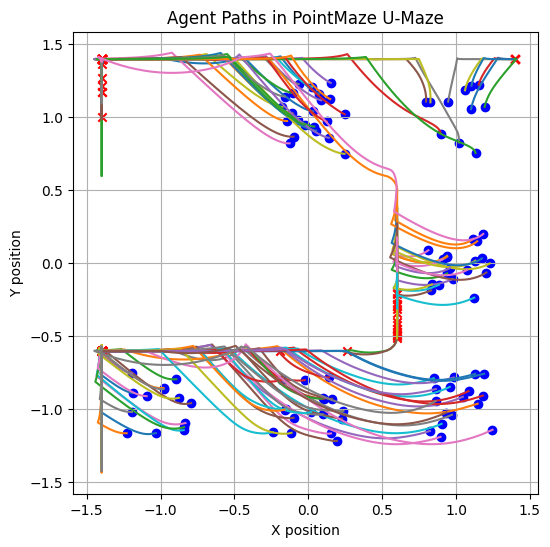

In [ ]:
import minari
import torch
import numpy as np
import matplotlib.pyplot as plt


dataset = minari.load_dataset("D4RL/pointmaze/umaze-v2", download=True)
env = dataset.recover_environment(eval_env=True)

device = "cuda" if torch.cuda.is_available() else "cpu"


def flatten_obs(obs):
    if isinstance(obs, dict):
        return np.concatenate([obs["observation"], obs["achieved_goal"], obs["desired_goal"]])
    return obs

def collect_path(env, actor, max_steps=300):
    obs, _ = env.reset()
    path = []
    total_reward = 0
    for t in range(max_steps):
        obs_vec = flatten_obs(obs)
        obs_t = torch.tensor(obs_vec, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            act = actor(obs_t).cpu().numpy()[0]
        obs, rew, done, trunc, info = env.step(act)
        total_reward += rew
        # record agent position (first two coords are x,y)
        if isinstance(obs, dict):
            pos = obs["observation"][:2]
        else:
            pos = obs[:2]
        path.append(pos)
        if done or trunc:
            break
    return np.array(path), total_reward

def plot_paths(env, actor, episodes=5):
    plt.figure(figsize=(6,6))
    plt.title("Agent Paths in PointMaze U-Maze")
    plt.xlabel("X position")
    plt.ylabel("Y position")

    # Plot maze walls (optional, if available)
    try:
        # Many Maze2D envs expose maze layout in env.maze structure
        maze = np.array(env.maze.maze_map)
        for i in range(maze.shape[0]):
            for j in range(maze.shape[1]):
                if maze[i,j] == 1:  # wall
                    plt.fill_between([j, j+1], i, i+1, color="gray", alpha=0.3)
    except:
        pass

    # Plot each rollout
    for ep in range(episodes):
        path, total_r = collect_path(env, actor)
        plt.plot(path[:,0], path[:,1], label=f"Ep {ep+1} (R={total_r:.2f})")
        plt.scatter(path[0,0], path[0,1], c="blue", marker="o", label="_start" if ep==0 else "")
        plt.scatter(path[-1,0], path[-1,1], c="red", marker="x", label="_goal" if ep==0 else "")

    plt.grid(True)
    plt.show()

plot_paths(env, actor, episodes=100)
